
## Setup
Import all the libraries needed

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

Load enviroment variables

In [16]:
INPUT_DIR = "./input"

Generate the pandas dataframe that will link each image to the corresponding whale from the csv file.
Show some values to assure it loaded correctly.

In [124]:
train_df = pd.read_csv(INPUT_DIR + "/train.csv")
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


Load two random whale images to assure folders are structured correctly

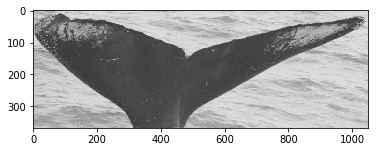

In [10]:
image = plt.imread("./input/train/00087b01.jpg")
plt.imshow(image)

In [125]:
def get_random_images(n):
    """Returns n lists of random images and images names pairs from the training dataset
        [[img_name1, img1], [img_name2, img2], ..., [img_name3, img3]]
    """
    train_sample = train_df.sample(n)
    images = [plt.imread(f'{INPUT_DIR}/train/{image_name}')  for image_name in train_sample["Image"]]
    return images

In [119]:
show_n_random_images(10)

[array([[[221, 221, 221],
         [223, 223, 223],
         [226, 226, 226],
         ...,
         [249, 249, 249],
         [249, 249, 249],
         [249, 249, 249]],
 
        [[218, 218, 218],
         [215, 215, 215],
         [210, 210, 210],
         ...,
         [249, 249, 249],
         [249, 249, 249],
         [249, 249, 249]],
 
        [[230, 230, 230],
         [222, 222, 222],
         [210, 210, 210],
         ...,
         [230, 230, 230],
         [230, 230, 230],
         [230, 230, 230]],
 
        ...,
 
        [[217, 217, 217],
         [210, 210, 210],
         [201, 201, 201],
         ...,
         [250, 250, 250],
         [250, 250, 250],
         [250, 250, 250]],
 
        [[217, 217, 217],
         [209, 209, 209],
         [198, 198, 198],
         ...,
         [209, 209, 209],
         [209, 209, 209],
         [209, 209, 209]],
 
        [[215, 215, 215],
         [210, 210, 210],
         [202, 202, 202],
         ...,
         [186, 186, 186],
  

In [127]:
def plot_random_images():
    images = get_random_images(10)
    figure = plt.figure(figsize=(15,3))
    
    for i, image in enumerate(images):
        subplot = figure.add_subplot(2,5,i+1)
        subplot.axis("Off")
        plt.imshow(image)

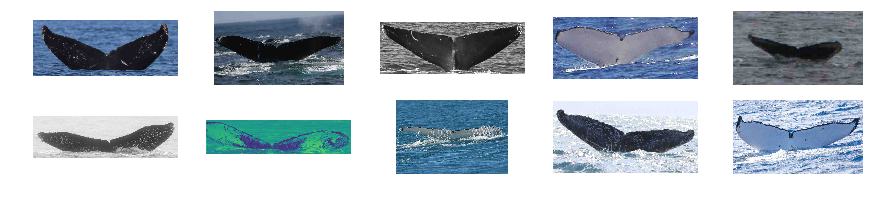

In [128]:
plot_random_images()